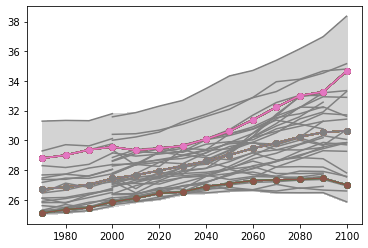

In [1]:
import pandas as pd
import os
from matplotlib import pyplot as plt

region = "CAM"
zone = "NSA"

parameters = ["tas_land", "pr_land"]

path = "../datasets-aggregated-regionally/data/CORDEX/CORDEX-{reg}_{param}".format(reg=region, param=parameters[0])

fig, ax = plt.subplots()


time_index = pd.date_range(start="1970-01-01", end="2100-01-01", freq='AS')
out = pd.DataFrame(index=time_index)

for f in os.listdir(path):
    df = pd.read_csv(os.path.join(path, f), header=15, usecols=['date', zone])
    df['date']  = pd.to_datetime(df['date'], format="%Y-%m", dayfirst=False)

    df.set_index(keys='date', drop=True, inplace=True)
    df_ann = df.resample(rule='AS').mean()
    out[f] = df_ann[zone]

out = out.groupby((out.index.year//10)*10).mean()

desc = out.T.describe(percentiles=[0.1, 0.9])
desc = desc.T

for c in out.columns:
    ax.plot(out.index, out[c], color='grey')
    ax.fill_between(desc.index, desc['min'], desc['max'], color='lightgrey')
   
    ax.plot(desc.index, desc['10%'], marker='o')
    ax.plot(desc.index, desc['90%'], marker='o')
    ax.plot(desc.index, desc['mean'], marker='o')



In [2]:
pd.__version__


'1.4.2'